# Spherical harmonics visualisation

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
from visualization.spherical_harmonics_visualization import plotAllHarmonicsUpToDegree

C:\Users\ressl\AppData\Local\Temp\ipykernel_12664\1232391595.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


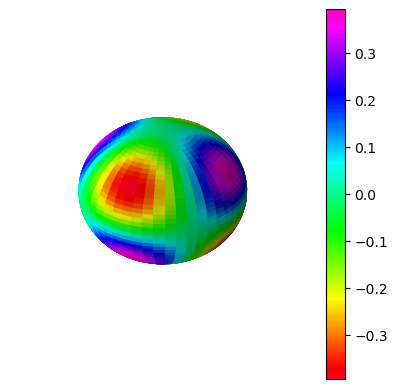

In [2]:
phi = np.linspace(0, np.pi, 50)
theta = np.linspace(0, 2*np.pi, 50)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

m, l = 2, 3

# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = sph_harm(m, l, theta, phi).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.gist_rainbow(fcolors))

# Create colorbar
sm = cm.ScalarMappable(cmap='gist_rainbow')
sm.set_clim(vmin=fmin, vmax=fmax)
cbar = plt.colorbar(sm)

# Turn off the axis planes
ax.set_axis_off()
plt.show()

C:\Users\ressl\Desktop\MSc Project\AlesMScProject\visualization\spherical_harmonics_visualization.py:130: RuntimeWarning: invalid value encountered in divide
  fcolors = (fcolors - fmin)/(fmax - fmin)


4 7 1
4 7 8
4 7 9
4 7 10
4 7 15
4 7 16
4 7 17
4 7 18
4 7 19
4 7 22
4 7 23
4 7 24
4 7 25
4 7 26
4 7 27
4 7 28


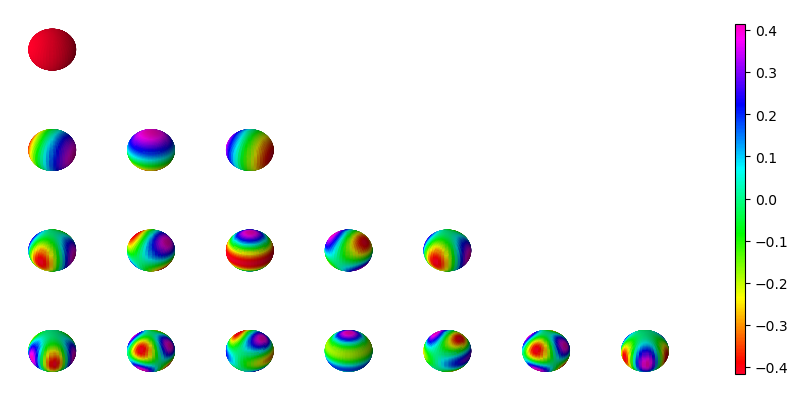

In [3]:
plotAllHarmonicsUpToDegree(3)